# Project 1: Watermark

The goal of this project is to add a given watermark on an image, with both files given (the examples below will use "watermark.png" and "etretat.png").

The following assumptions have been made:

* the watermark image is smaller than the photograph (this will almost always be the case)
* the photograph is a color image: it would be easy to adapt this to also take mono channel images, but has not been done
  to keep the number of functions in the project to a reasonable amount.
* the image is in rgb format: if it's not the case, the user must first convert the image (e.g. with rgb2hsv)


The program has 3 "opacity" modes:

* simple: all the necessary pixels become white
* transparent: takes a optional argument 'opacity', which determines how much lighter (if it's positive) or darker (if it's negative) the necessary pixels must become.
* average: similar to the previous one, but the value is computed automatically based on the average luminosity in the neighbourhood. 

It also has 2 "crop" modes, which are relevant if the region in which the watermark must be applied goes out of the image bounds:

* crop: everything that is out of bounds is simply cropped (not represented).
* loop-back: everything that is out of bounds comes back on the other side.

## 1.Crop mode

In this version, for all transparency options, we will first compute the max value of the pixels on which to apply the transformation (it's simply the starting value + the size of the watermark in that dimension). Then, if that value if bigger than the photograph in any dimension, the max value is updated to that size, and the watermark is cropped accordingly.


### 1.1 Simple

Here, after knowing the range of values in which we must operate, we only have to check where in that range the pixels of the watermark are white, and set corresponding pixels of the image to white. Numpy makes this very easy for us with its conditional indexing: "im2[y:max_y, x:max_x][watermark>254]" returns all pixels in the given range where the watermark has value 255. 

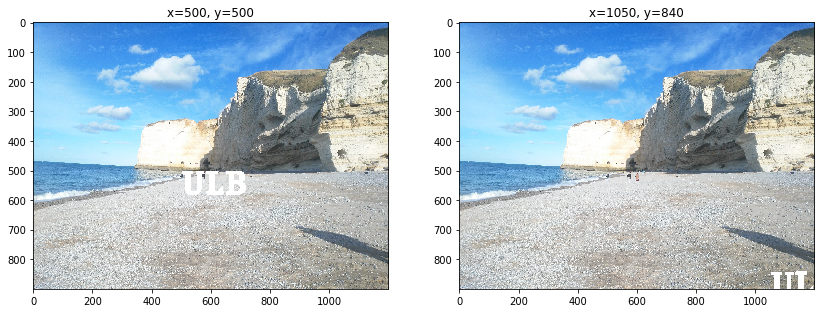

In [41]:
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def watermark_simple_crop(im, y, x, watermark):
    max_y =  y + watermark.shape[0]
    max_x =  x + watermark.shape[1]
    
    if im.shape[0] < max_y:
        max_y = im.shape[0]
        watermark = watermark[:im.shape[0]-y]  #crop the watermark
    if im.shape[1] < max_x:
        max_x = im.shape[1]
        watermark = watermark[:, :im.shape[1]-x]
        
    im2 = im.copy()
    im2[y:max_y, x:max_x][watermark>254] = [255, 255, 255]
    
    return im2 


## import picture and watermark

beach = imread("etretat.jpg")
watermark = imread("watermark.png")
####


simple_crop1 = watermark_simple_crop(beach, 500, 500, watermark)
simple_crop2 = watermark_simple_crop(beach, 840, 1050, watermark)

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.imshow(simple_crop1)
plt.title("x=500, y=500")

plt.subplot(1, 2, 2)
plt.imshow(simple_crop2)
plt.title("x=1050, y=840")
plt.show()

### 1.2 Transparent

This mode is very similar to the first one, we only have to replace the assignment to 255 with an incrementation by the given value (default value of 50). Actually, it's so similar that we will be able to redefine the simple version, by passing 255 as opacity. Since we're conveerting to 'int16', there will be no overflow. Before converting back to 'uint8', we make sure there are no pixels over 255 or under 0. 

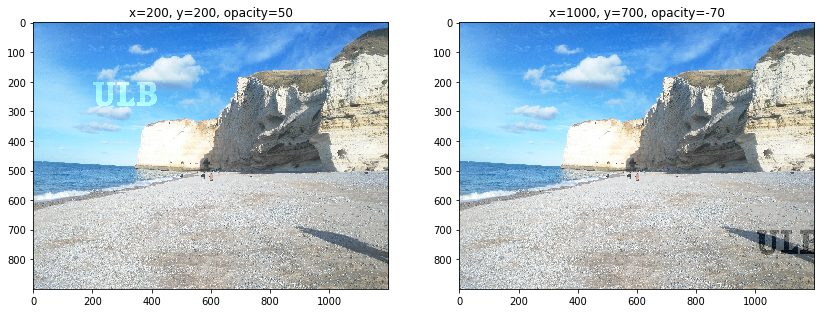

In [73]:

def watermark_transparent_crop(im, y, x, watermark, opacity=50):
    im = im.astype('int16')
    max_y =  y + watermark.shape[0]
    max_x =  x + watermark.shape[1]
    
    if im.shape[0] < max_y:
        max_y = im.shape[0]
        watermark = watermark[:im.shape[0]-y]  # crop the watermark
    if im.shape[1] < max_x:
        max_x = im.shape[1]
        watermark = watermark[:, :im.shape[1]-x]
        
    im2 = im.copy()
    im2[y:max_y, x:max_x][watermark>254] += np.array([opacity, opacity, opacity])
    im2[im2>255] = 255
    im2[im2<0] = 0
    return im2.astype(np.uint8)

def watermark_simple_crop(im, y, x, watermark):
    return watermark_transparent_crop(im, y, x, watermark, 255)


transparent_crop1 = watermark_transparent_crop(beach, 200, 200, watermark, 50)
transparent_crop2 = watermark_transparent_crop(beach, 700, 1000, watermark, -70) 
   
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.imshow(transparent_crop1 )
plt.title("x=200, y=200, opacity=50")

plt.subplot(1, 2, 2)
plt.imshow(transparent_crop2)
plt.title("x=1000, y=700, opacity=-70")
plt.show()

### 1.3 Average

First, we must compute the average value of a pixel: this is fairly easy if we use the sum method of a numpy array. We must divide that by the number of pixels in bounds times 3 (because there are 3 channels). If the background is considered light (the average value is over 127) we will make the chosen pixels darker, and vice-versa. 

The value we will add or subtract from those pixels is equal to the average value times a factor given by the user. After a few experiments, it looks like values between 0.3 (for lighter backgrounds) and 0.8 (for darker backgrounds) work best: for this reason, the argument has a default value of 0.5. If the factor is less than 0.3, the watermark is only barely visible, and if's higher than 0.8, it's  too "intrusive".


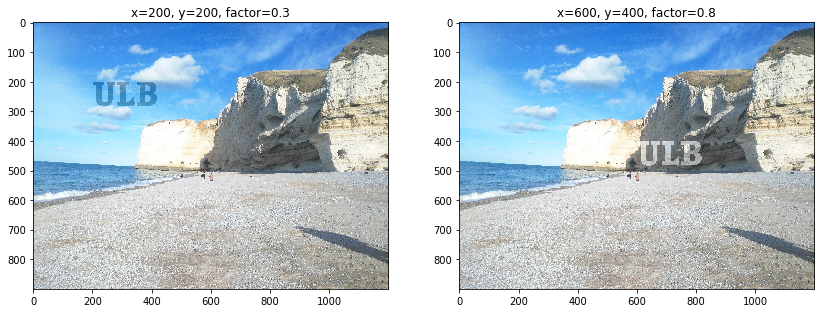

In [72]:
def watermark_average_crop(im, y, x, watermark, factor=0.5):
    im = im.astype('int16')
    max_y =  y + watermark.shape[0]
    max_x =  x + watermark.shape[1]
    
    
    if im.shape[0] < max_y:
        max_y = im.shape[0]
        watermark = watermark[:im.shape[0]-y]
    if im.shape[1] < max_x:
        max_x = im.shape[1]
        watermark = watermark[:, :im.shape[1]-x]
        
    im2 = im.copy()
    avg = (im2[y:max_y, x:max_x].sum())/((max_y-y)*(max_x-x)*3)
    
    if (avg>127):
        factor *= -1
    to_add = int(avg*factor)


    im2[y:max_y, x:max_x][watermark>254] += np.array([to_add, to_add, to_add])
    
    im2[im2>255] = 255
    im2[im2<0] = 0
    
    return im2.astype('uint8')

average_crop1 = watermark_average_crop(beach, 200, 200, watermark, 0.3)
average_crop2 = watermark_average_crop(beach, 400, 600, watermark, 0.8) 
   
plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.imshow(average_crop1 )
plt.title("x=200, y=200, factor=0.3")

plt.subplot(1, 2, 2)
plt.imshow(average_crop2)
plt.title("x=600, y=400, factor=0.8")
plt.show()

## 2. Loop mode